In [1]:
#Librerias
from numpy import *
from scipy import *
from scipy.special import *
from scipy.integrate import *
from pylab import *
from matplotlib.pyplot import *
%matplotlib inline

In [2]:
#Se define la forma que va a tener el campo magnetico
#Las variables que hay que considerar son las siguientes
# I->      la corriente
# a->      el radio de la espira
# h->      la altura a la que se encuentra la espira
# r_vec->  el punto en el espacio en el cual queremos calcular el campo magnético

def campo_mag(I, a, h, r_vec, f=0):
    # r_vec va a estar dado en coordenadas cilindricas (r, z, phi)
    r = r_vec[0]
    z = r_vec[1]

    #f va a servir de bandera ya que el campo magnetico depende del valor de r
    # El factor de 0.001 corresponde a pasar a unidades de Gauss
    if f==0:
    # si r <> 0 entonces 
        k2 = (4*a*r)/((r+a)**2+(z-h)**2)
        B_z = I*(2/sqrt((a+r)**2+(z-h)**2))*(ellipk(k2) + ellipe(k2)*((a**2-r**2-(z-h)**2)/((a-r)**2+(z-h)**2)))
        B_r = I*((z-h)/r)*(2/sqrt((a+r)**2+(z-h)**2))*(-ellipk(k2) + ellipe(k2)*((a**2+r**2+(z-h)**2)/((a-r)**2+(z-h)**2)))

    elif f==1:
    # si r = 0 entonces 
        B_r = 0.
        B_z = (2*pi*I*a**2)/sqrt((a**2+(z-h)**2)**3)

    #Se regresa el valor del campo magnetico en las direcciones radial y axial en unidades de Gauss
    return 0.001*B_r, 0.001*B_z

In [3]:
#Se define una funcion que va a calcular el campo magnetico de un arreglo de espiras
#La forma en que lo hace es haciendole pasar un arreglo de radios y alturas y corrientes, a=[...], h=[...], I=[...]
#de forma sumael campo para cada caso, nota a, h e I deben de tener la misma dimension
def campo(I, a, h, r_vec, f=0):
    B_r, B_z = 0., 0.
    #Itera sobre las espiras
    for i in range(len(h)):
        B_i = campo_mag(I[i], a[i], h[i], r_vec, f)
        B_r = B_r + B_i[0]
        B_z = B_z + B_i[1]
    return B_r, B_z

In [12]:
def bobina_cilindrica(i, H, R, d, Nx, Ny, cnt_levels=[], mallalimxy = [300,1.0e-2,1.0e-2]):
    """
        Argumentos de la funcion
            i  ->  Corriente
            H  ->  Distancia en la direccion z AL CENTRO DEL ARREGLO
            R  ->  Distancia en la direccion r AL CENTRO DEL ARREGLO
            d  ->  Diametro de las espiras
            Nx ->  Numero de espiras en la direccion r
            Ny ->  Numero de espiras en la direccion z
    """
    
    #Se crea el arreglo de las espiras
    I, a, h = espiras(i, H, R, d, Nx, Ny)

    #Se crea una malla en donde se van a evaluar los campos magneticos
    N_malla = int(mallalimxy[0])
    n, m = mallalimxy[1], mallalimxy[2]
    R_min, R_max, Z_min, Z_max = -n, n, -m, m
    r, z = linspace(R_min, R_max, N_malla), linspace(Z_min, Z_max, N_malla)
    
    #Se crea una malla 2D
    R, Z = meshgrid(r,z)
    
    #Se crean mallas "1D" a lo largo de los ejes axial y radial
    R0, Z0 = meshgrid(zeros(len(z)), z) #Axial
    R1, Z1 = meshgrid(r, zeros(len(r))) #Radial
    
    #Se calcula en campo magnetico en la malla 2D
    b_r, b_z = campo(I, a, h, [R,Z])
    B = sqrt(b_r**2+b_z**2)
    
    #Se calcula el campo magnetico en el centro
    b_r0, b_z0 = campo(I, a, h, [0., 0.], 1)
    B0 = sqrt(b_r0**2+b_z0**2)

    #Se calcula el campo magnetico a lo largo del eje Axial
    b_r_0, b_z_0 = campo(I, a, h, [R0, Z0], 1)
    B_0 = sqrt(b_r_0**2+b_z_0**2)
    
    #Se calcula el campo magnetico a lo largo del eje Radial
    b_r_1, b_z_1 = campo(I, a, h, [R1, Z1])
    B_1 = sqrt(b_r_1**2+b_z_1**2)
    
    RGRAD, ZGRAD = [],[]
    RCURV, ZCURV = [],[]
    R_GRAD, Z_GRAD = [],[]
    R_CURV, Z_CURV = [],[]

    for i in range(1, N_malla-1):
        RGRAD.append((B_1[0,i+1]-B_1[0,i-1])/(2.*100.*2.0*n/N_malla))
        ZGRAD.append((B_0[i+1,0]-B_0[i-1,0])/(2.*100.*2.0*m/N_malla))
        R_GRAD.append(R1[0,i])
        Z_GRAD.append(Z0[i,0])
        if 1 < i < N_malla-2:
            RCURV.append((B_1[0,i+1]+B_1[0,i-1]-2*B_1[0,i])/(100.*2.0*n/N_malla)**2)
            ZCURV.append((B_0[i+1,0]+B_0[i-1,0]-2*B_0[i,0])/(100.*2.0*m/N_malla)**2)
            R_CURV.append(R1[0,i])
            Z_CURV.append(Z0[i,0])
    
    
    dist = 1.0e-3
    D = 2.*n
    #Se calcula el gradiente de la magnitud de campo magnetico a 1mm de distancia del centro    
    r_g0 = 1000*R_GRAD[N_malla/2-1+int(dist*N_malla/D)]
    gradr0 = RGRAD[N_malla/2-1+int(dist*N_malla/D)]
    z_g0 = 1000*Z_GRAD[N_malla/2-1+int(dist*N_malla/D)]
    gradz0 = ZGRAD[N_malla/2-1+int(dist*N_malla/D)]
    
    #Se calcula la curvatura de la magnitud de campo magnetico
    r_c0 = 1000*R_CURV[N_malla/2-1+int(dist*N_malla/D)]
    curvr0 = RCURV[N_malla/2-2+int(dist*N_malla/D)]
    z_c0 = 1000*Z_CURV[N_malla/2-1+int(dist*N_malla/D)]
    curvz0 = ZCURV[N_malla/2-2+int(dist*N_malla/D)]
    
    #Hasta ahora todas las unidades de longitud han sido en metros, por ser mas 
    #comodo se cambian las unidades  a centrimetros
    Z = 100*Z
    R = 100*R
    Z0_ = [100*x for x in Z0[:,0]] 
    R1_ = [100*x for x in R1[0]]
    R_GRAD = [100*x for x in R_GRAD] 
    Z_GRAD = [100*x for x in Z_GRAD] 
    R_CURV = [100*x for x in R_CURV] 
    Z_CURV = [100*x for x in Z_CURV] 
    
    print u"Valor del campo magnético en el centro es "+str(B0)+" Gauss"
    print u"Valor del gradiente campo magnético axial en z="+str(trunc(100*z_g0)/100)+" mm  es "+str(gradz0)+" Gauss/cm"
    print u"Valor del gradiente campo magnético radial en r="+str(trunc(100*r_g0)/100)+" mm  es "+str(gradr0)+" Gauss/cm"
    print u"Valor de las curvaturas del campo magnético axial en z="+str(trunc(100*z_c0)/100)+" mm  es "+str(curvz0)+" Gauss/cm^2"
    print u"Valor de las curvaturas del campo magnético radial en r="+str(trunc(100*r_c0)/100)+" mm  es "+str(curvr0)+" Gauss/cm^2"

    f, ((ax, bx), (cx, dx)) = plt.subplots(2, 2, figsize=(14, 14))
    
    if cnt_levels==[]:
        if tipo=='H':
            contour_levels = linspace(0.9*B0, 1.1*B0, 30)
        else:
            contour_levels = linspace(0, 1.5*max(amax(B_1[0]), amax(B_0[:,0])), 30)
    else:
        contour_levels = cnt_levels
        
    cs = ax.contourf(R, Z, B, contour_levels , corner_mask=True)
    ax.contour(cs, colors='k')
    ax.grid(c='k', ls='-', alpha=0.3)
    ax.streamplot(R, Z, b_r, b_z, color='r')
    ax.axis([100*R_min, 100*R_max, 100*Z_min, 100*Z_max])
    ax.set_aspect('equal', 'datalim')

    ax.set_xlabel ('Direccion radial (cm)') 
    ax.set_ylabel ('Direccion Z (cm)')
    ax.set_title(u'Dirección del campo magnetico')
    
    bx.plot(Z0_, B_0[:,0], label='Eje z', color='r')
    bx.plot(R1_, B_1[0], label='Eje r', color='b')
    bx.legend()
    bx.grid()
    bx.set_xlabel ('Direccion al centro (cm)') 
    bx.set_ylabel (u'Magnitud del campo magnético (G)')
    bx.set_title(u"Campo magnético a lo largo de los ejes")
    bx.set_xlim(min(100*Z_min,100*R_min), max(100*Z_max,100*R_max))
    
    cx.plot(R_GRAD, RGRAD, label='Eje z', color='r')
    cx.plot(Z_GRAD, ZGRAD, label='Eje r', color='b')
    cx.legend()
    cx.grid()
    cx.set_xlabel ('Direccion al centro (cm)') 
    cx.set_ylabel (u'Magnitud del campo magnético (G/cm)')
    cx.set_title(u"Perfil del gradiente del campo magnético")
    cx.set_xlim(min(100*Z_min,100*R_min), max(100*Z_max,100*R_max))
    
    dx.plot(R_CURV, RCURV, label='Eje z', color='r')
    dx.plot(Z_CURV, ZCURV, label='Eje r', color='b')
    dx.legend()
    dx.grid()
    dx.set_xlabel ('Direccion al centro (cm)') 
    dx.set_ylabel (u'Magnitud del campo magnético (G/cm^2)')
    dx.set_title(u"Perfil de la curvatura del campo magnético")
    dx.set_xlim(min(100*Z_min,100*R_min), max(100*Z_max,100*R_max))
    show()

Argumentos de la funcion

    i  ->  Corriente
    
    H  ->  Distancia en la direccion z AL CENTRO DEL ARREGLO
    
    R  ->  Distancia en la direccion r AL CENTRO DEL ARREGLO
    
    d  ->  Diametro de las espiras
    
    Nx ->  Numero de espiras en la direccion r
    
    Ny ->  Numero de espiras en la direccion z

In [66]:
def espiras(i, H, R, d, Nx, Ny):
    #Se crea un arreglo de espiras en configuracion de Nx x Ny espiras en la direccion Z+ y en Z-
    #Formando un arreglode bobinas en configuracion Helmholz
    I, a, h = [], [], []
    for k in range(Ny):
        for j in range(Nx):
            I.append(i)
            h.append(-H-d/2.-d*k)
            a.append(R+d/2.+d*j)
            
            I.append(i)
            h.append(H+d/2.+d*k)
            a.append(R+d/2.+d*j)
    return I, a, h

Valor del campo magnético en el centro es 47.4746828305 Gauss
Valor del gradiente campo magnético axial en z=0.5 mm  es 0.048639107253 Gauss/cm
Valor del gradiente campo magnético radial en r=0.5 mm  es -0.0246456093375 Gauss/cm
Valor de las curvaturas del campo magnético axial en z=1.52 mm  es 0.966903372555 Gauss/cm^2
Valor de las curvaturas del campo magnético radial en r=1.52 mm  es -0.489933391728 Gauss/cm^2


/Users/diego/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:94: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.


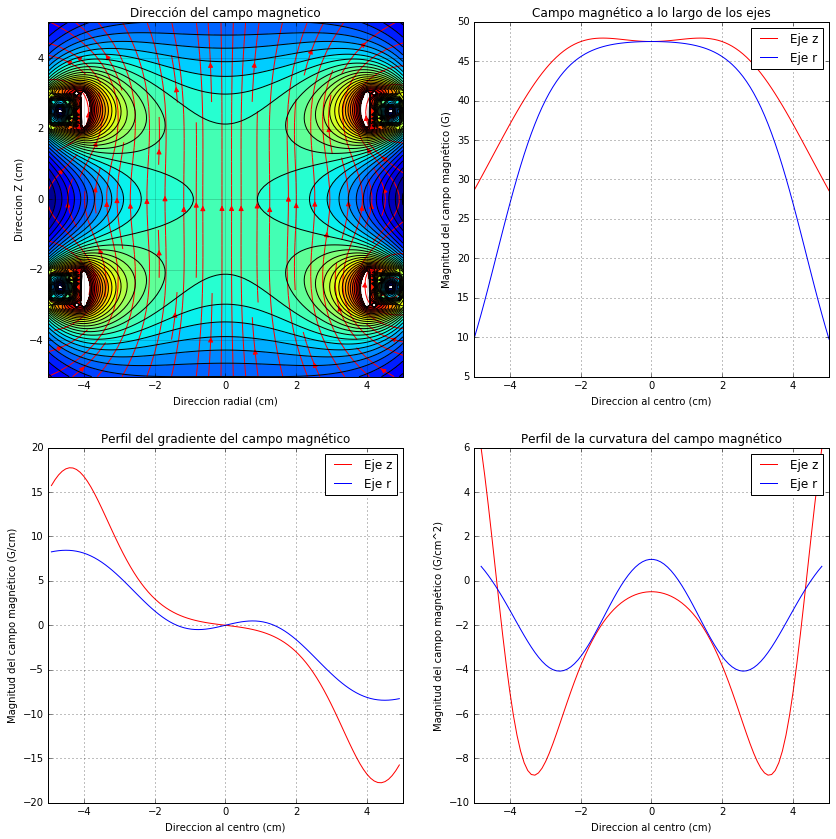

In [101]:
i, H, R, d, Nx, Ny = 1., 2.0e-2, 4.0e-2, 0.644e-3, 16, 16
bobina_cilindrica(i, H, R, d, Nx, Ny, cnt_levels=linspace(10,100,30), mallalimxy = [100,R+Nx*d, 2.*H+Ny*d])